# Preprocessing Data to `protein_embeddings.parquet`
The following cells were used to first preprocess the train.csv file to create the mutated sequences. Then, we run the ESM model to get the embeddings and store these in a parquet file for later use.

In [3]:
import pandas as pd

In [2]:
df = pd.read_csv('train.csv')

# get the sequence
seq = open('sequence.fasta', 'r').read()
seq = seq.split("\n")[1]

# create each mutated sequence using the info
sequences = []
for i in df['mutant']:
    ind = int(i[1:-1])
    tmp = seq[:ind] + i[-1] + seq[ind+1:]
    sequences.append(tmp)
df['Sequence'] = sequences

In [2]:
import torch
import esm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ESM model and move it to GPU
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()  # Example: ESM-2 model
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()  # Set to eval mode

# Extract ESM embeddings using GPU
def extract_esm_embedding(sequence):
    batch_labels, batch_strs, batch_tokens = batch_converter([(None, sequence)])
    batch_tokens = batch_tokens.to(device)  # Move input to GPU

    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
    
    token_representations = results["representations"][33]  # Use final layer
    sequence_embedding = token_representations.mean(dim=1).squeeze().cpu().numpy()  # Move back to CPU for NumPy
    return sequence_embedding

Using device: cuda


In [8]:
# load and merge in query 1 results
df_query1 = pd.read_csv('query1.csv')
df_query1.rename(columns={"sequence": "Sequence"}, inplace=True)

df = pd.concat([df, df_query1], ignore_index=True)

In [9]:
# Apply embedding extraction
df["Embedding"] = df["Sequence"].apply(lambda seq: extract_esm_embedding(seq))

df.to_parquet("protein_embeddings.parquet", engine="pyarrow")

KeyboardInterrupt: 

# Training Models
We initially train a MLP, LightGBM, and XGBoost.

In [4]:
df = pd.read_parquet('protein_embeddings.parquet')

In [5]:
df

,mutant,DMS_score,Sequence,Embedding
0,M0Y,0.2730,YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027215108, -0.07895891, 0.024665592, 0.0871..."
1,M0W,0.2857,WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027446767, -0.08002912, 0.024973774, 0.0876..."
2,M0V,0.2153,VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027746048, -0.08058312, 0.024816252, 0.0884..."
3,M0T,0.3122,TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027021278, -0.07973976, 0.024042634, 0.0892..."
4,M0S,0.2180,SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027436633, -0.07952297, 0.02438334, 0.09035..."
...,...,...,...,...
1135,P347D,0.3876,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.028119618, -0.0787422, 0.024685634, 0.08421..."
1136,P347C,0.1837,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.028140698, -0.07920752, 0.024998326, 0.0859..."
1137,P347A,0.4611,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.028426215, -0.079440005, 0.025145365, 0.084..."
1138,P347M,0.2412,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.028294036, -0.079212606, 0.025009708, 0.085..."


Text(0.5, 1.0, 'Total Dataset Labels')

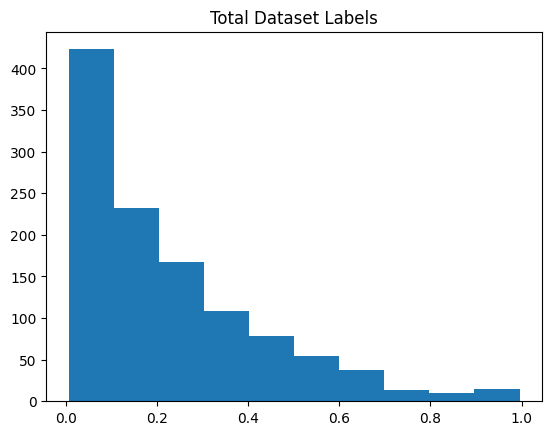

In [109]:
plt.hist(df.DMS_score)
plt.title("Total Dataset Labels")

In [110]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = np.vstack(df["Embedding"].values)
y = df["DMS_score"].values

# Convert to PyTorch tensors and move to GPU
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)  # Reshape for MLP

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


## MLP

In [113]:
from scipy.stats import spearmanr

# Define a simple MLP regression model using GPU
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single output value
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss function, and optimizer
model = MLPRegressor(input_dim=X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 2000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = criterion(test_predictions, y_test)
print(f"Test MSE: {test_loss.item():.4f}")

spearman_corr_xgb, _ = spearmanr(y_test.cpu().numpy().flatten(), test_predictions.cpu().numpy().flatten())
print(f"MLP Spearman Correlation: {spearman_corr_xgb:.4f}")

Epoch 1000/2000, Loss: 0.0634
Epoch 2000/2000, Loss: 0.0465
Test MSE: 0.0478
MLP Spearman Correlation: 0.2390


## XGBoost

In [114]:
import xgboost as xgb
from scipy.stats import spearmanr

# Convert to DMatrix (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train.cpu().numpy(), label=y_train.cpu().numpy().flatten())
dtest = xgb.DMatrix(X_test.cpu().numpy(), label=y_test.cpu().numpy().flatten())

# Train XGBoost Model
params = {"objective": "reg:squarederror", "eval_metric": "rmse"}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict
y_pred_xgb = xgb_model.predict(dtest)

# Compute Spearman correlation
spearman_corr_xgb, _ = spearmanr(y_test.cpu().numpy().flatten(), y_pred_xgb)
print(f"XGBoost Spearman Correlation: {spearman_corr_xgb:.4f}")


XGBoost Spearman Correlation: 0.4297


## LightGBM

In [115]:
import lightgbm as lgb

# Train LightGBM Model
lgb_train = lgb.Dataset(X_train.cpu().numpy(), label=y_train.cpu().numpy().flatten())

params = {"objective": "regression", "metric": "rmse"}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

# Predict
y_pred_lgb = lgb_model.predict(X_test.cpu().numpy())

# Compute Spearman correlation
spearman_corr_lgb, _ = spearmanr(y_test.cpu().numpy().flatten(), y_pred_lgb)
print(f"LightGBM Spearman Correlation: {spearman_corr_lgb:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326399
[LightGBM] [Info] Number of data points in the train set: 1012, number of used features: 1280
[LightGBM] [Info] Start training from score 0.272192
LightGBM Spearman Correlation: 0.4446


# Ensemble of LightGBM & Linear Regression 
We use linear regression to weigh the different models in the ensemble instead of taking the mean. We use boostrapping to train each model on a different subset of the data.

In [77]:
y_train.max()

tensor(0.9909, device='cuda:0')

In [ ]:
# Step 1 - Train Ensemble
import lightgbm as lgb
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
from sklearn.utils import resample

# Define hyperparameters for LightGBM
lgb_params = {"objective":"regression", "metric": "rmse", 'learning_rate': 0.0436032560500989,  'num_leaves': 76, 'min_child_samples': 6, 'max_depth': 7, 'subsample': 0.5939560221912161, 'colsample_bytree': 0.6618044618804528, }

# Number of bootstrapped models
num_bootstraps = 100
lgb_boot_models = []
lgb_predictions = []

progress = tqdm(total=num_bootstraps, desc="Training Bootstrapped LightGBM Models")

for i in range(num_bootstraps):
    # Bootstrap resampling
    X_resampled, y_resampled = resample(X_train.cpu().numpy(), y_train.cpu().numpy().flatten(), replace=True, n_samples=X_train.shape[0], random_state=i)

    # Train LightGBM model on resampled data
    lgb_train = lgb.Dataset(X_resampled, label=y_resampled)
    lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=100)
    
    # Store trained model
    lgb_boot_models.append(lgb_model)

    # Predict on test set
    y_pred_lgb = lgb_model.predict(X_test.cpu().numpy())
    lgb_predictions.append(y_pred_lgb)

    progress.update(1)

progress.close()

# Average predictions from bootstrapped models
y_pred_ensemble = np.mean(np.column_stack(lgb_predictions), axis=1)

# Compute Spearman correlation
spearman_corr_ensemble, _ = spearmanr(y_test.cpu().numpy().flatten(), y_pred_ensemble)

print(f"Bootstrapped LightGBM Ensemble Spearman Correlation: {spearman_corr_ensemble:.4f}")


In [49]:
# Step 2: Train Meta Predictor

from sklearn.linear_model import Ridge

progress = tqdm(total=len(lgb_boot_models), desc="Generating `X_meta_train`")
X_meta_train = []
for m in lgb_boot_models:
    X_meta_train.append(m.predict(X_train.cpu().numpy()))
    progress.update(1)

progress.close()

X_meta_train = np.column_stack(X_meta_train)
y_meta_train = y_train.cpu().numpy().flatten()


# Train a Ridge Regression as the meta-model
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta_train, y_meta_train)

## EVAL::
# Predict with stacked model
progress = tqdm(total=len(lgb_boot_models), desc="Predicting for `X_meta_test`")
X_meta_test = []
for m in lgb_boot_models:
    X_meta_test.append(m.predict(X_test.cpu().numpy()))
    progress.update(1)
progress.close()
X_meta_test = np.column_stack(X_meta_test)
y_meta_test = y_train.cpu().numpy().flatten()

y_meta_pred = meta_model.predict(X_meta_train)

# Compute Spearman correlation
spearman_corr_stacked, _ = spearmanr(y_meta_test, y_meta_pred)
print(f"Meta LightGBM Model Spearman Correlation: {spearman_corr_stacked:.4f}")


Predicting for `X_meta_test`: 100%|██████████| 100/100 [00:00<00:00, 559.18it/s]

(1012,) (1012,)
Meta LightGBM Model Spearman Correlation: 0.9550


# Predictions

In [19]:
df_test = pd.read_parquet('protein_embeddings_test.parquet')
X_unlabeled = df_test['Embedding'].values

In [20]:
X_unlabeled = np.vstack(X_unlabeled)
X_unlabeled = torch.tensor(X_unlabeled, dtype=torch.float32, device=device)

In [21]:
import numpy as np

# Compute UCB for LightGBM ensemble

y_pred_all = np.column_stack([model.predict(X_unlabeled.cpu().numpy()) for model in lgb_boot_models])
std_pred = np.std(y_pred_all, axis=1)    # Uncertainty (std dev)
mean_pred = meta_model.predict(y_pred_all)

In [22]:
# Rohan's Version
ucb_scores = mean_pred + 2 * std_pred
top_mutations = np.argsort(ucb_scores)[-100:]
df_test.iloc[top_mutations]['mutant'].values

array(['E122R', 'D80R', 'E398V', 'E3L', 'N486I', 'F223I', 'D401I',
       'P342I', 'G246A', 'E15Y', 'E168V', 'E468V', 'D103I', 'G186V',
       'E340R', 'E552I', 'N546W', 'D637R', 'E379K', 'E168R', 'D27I',
       'S9Y', 'E468R', 'Q146Y', 'E340V', 'D360R', 'W560I', 'D381I',
       'N648I', 'N546L', 'N614V', 'E414R', 'Q570Y', 'N486Y', 'H353I',
       'N648Y', 'E600R', 'E600I', 'G386I', 'E278V', 'D637F', 'D99L',
       'E640V', 'E299I', 'D37I', 'G246V', 'E415V', 'G186A', 'S351Y',
       'G86V', 'D187I', 'S483Y', 'E15K', 'E600Y', 'Q476Y', 'S411Y',
       'E600V', 'E168I', 'E3V', 'E359I', 'N643Y', 'Q163Y', 'Q277Y',
       'E135R', 'S20Y', 'E379V', 'N648M', 'E15W', 'E15V', 'Q132Y',
       'Q484Y', 'E274R', 'Q526Y', 'G446A', 'D190I', 'S409Y', 'E3W', 'G6A',
       'N546Y', 'N486L', 'S429Y', 'S113Y', 'Q378Y', 'E3R', 'E428K',
       'E307V', 'S54Y', 'S183Y', 'Q508Y', 'N74Y', 'N614Y', 'P257I',
       'E165V', 'E428R', 'E640W', 'N488M', 'N486M', 'E358V', 'N488Y',
       'N546M'], dtype=object)

(array([   5.,   56.,  934., 1871., 1996., 2277., 1949., 1612.,  540.,
          84.]),
 array([0.50864518, 0.51563529, 0.5226254 , 0.52961551, 0.53660562,
        0.54359574, 0.55058585, 0.55757596, 0.56456607, 0.57155618,
        0.57854629]),
 <BarContainer object of 10 artists>)

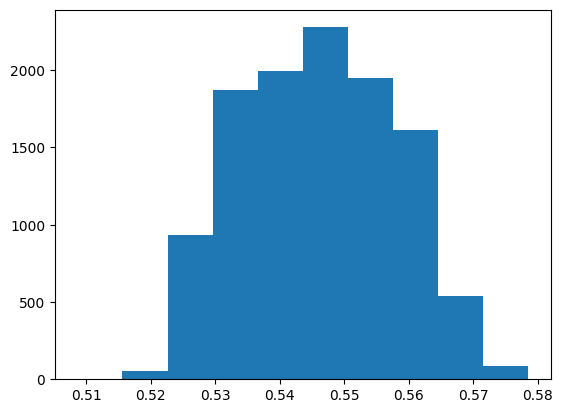

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(ucb_scores)

In [18]:
# Sai's Version
ucb_scores = std_pred
top_mutations = np.argsort(ucb_scores)[-100:]
df_test.iloc[top_mutations]['mutant'].values

array(['L589G', 'E231N', 'E468G', 'W499N', 'L631P', 'L155N', 'F579T',
       'L125G', 'L75T', 'L642G', 'A510G', 'F59G', 'A395G', 'I478G',
       'F514G', 'L639P', 'D624Y', 'E184N', 'A301G', 'A310G', 'L525T',
       'F64G', 'F206G', 'R265P', 'A83G', 'L471T', 'L404P', 'V282G',
       'L466A', 'L627T', 'R265N', 'L273N', 'I487G', 'E427N', 'L627G',
       'E274N', 'F230G', 'R387G', 'L155T', 'L10G', 'A327G', 'I364G',
       'D613N', 'D494N', 'L213N', 'F365G', 'E278G', 'L317M', 'I547G',
       'L407G', 'L125T', 'D288N', 'E414N', 'D244N', 'F563G', 'P626G',
       'L452G', 'L14G', 'L631T', 'F63C', 'I607G', 'L459P', 'L539P',
       'E640N', 'W560T', 'L525P', 'W348P', 'L75P', 'W454N', 'L147G',
       'L466T', 'E166N', 'D37Q', 'F431G', 'E46N', 'A349G', 'F256G',
       'I481G', 'A367G', 'V634G', 'L641G', 'L346T', 'M580G', 'I496G',
       'L300M', 'L155G', 'I181G', 'F405G', 'F238G', 'F434G', 'L620M',
       'D187G', 'I374G', 'L121G', 'L267G', 'W94P', 'F171G', 'L346M',
       'D91G', 'L639G'], dtype=

In [23]:
arr = list(df_test.iloc[top_mutations]['mutant'].values)
f = open('query2.txt','w')
for i in arr:
    f.write(i+'\n')
f.close()

In [24]:
# TODO: Delete me
# test
sai_test = []
with open("query1.txt", "r") as f:
    data = f.read()
    sai_test = data.splitlines()
rohan_test = []
with open("query2.txt", "r") as f:
    data = f.read()
    rohan_test = data.splitlines()

val = len(set(rohan_test) & set(sai_test))
print(val)

100


# Generating protein_embeddings_test.parquet

In [92]:
import torch
import esm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ESM model and move it to GPU
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()  # Example: ESM-2 model
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()  # Set to eval mode

# Extract ESM embeddings using GPU
def extract_esm_embedding(sequence):
    batch_labels, batch_strs, batch_tokens = batch_converter([(None, sequence)])
    batch_tokens = batch_tokens.to(device)  # Move input to GPU

    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
    
    token_representations = results["representations"][33]  # Use final layer
    sequence_embedding = token_representations.mean(dim=1).squeeze().cpu().numpy()  # Move back to CPU for NumPy
    return sequence_embedding

Using device: cuda


In [24]:
df_test = pd.read_csv('test.csv')
df_test['Sequence'] = df_test['mutant'].apply(lambda x: seq[:int(x[1:-1])] + x[-1] + seq[int(x[1:-1])+1:])
df_test['Embedding'] = df_test['Sequence'].apply(lambda seq: extract_esm_embedding(seq))
df_test.to_parquet("protein_embeddings_test.parquet", engine="pyarrow")

KeyboardInterrupt: 

# Finding Optimal Hyperparams for LightGBM

In [ ]:
#Best LightGBM Parameters: {'learning_rate': 0.04931791757724383, 'num_leaves': 85, 'min_child_samples': 48, 'max_depth': 7, 'subsample': 0.5749253739933733, 'colsample_bytree': 0.8371746709650121}
import optuna

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }

    lgb_train = lgb.Dataset(X_train.cpu().numpy(), label=y_train.cpu().numpy().flatten())
    lgb_model = lgb.train(params, lgb_train, num_boost_round=100)
    
    y_pred = lgb_model.predict(X_test.cpu().numpy())
    spearman_corr, _ = spearmanr(y_test.cpu().numpy().flatten(), y_pred)
    
    return spearman_corr

# Run Bayesian Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best parameters
print("Best LightGBM Parameters:", study.best_params)


# Best Beta
There is not much difference amongst the top options, so we just use 1.5 for simplicity.

In [ ]:
import optuna
from scipy.stats import spearmanr

# Function to optimize beta
def optimize_beta(trial):
    beta = trial.suggest_uniform("beta", 0.1, 5.0)  # Search range
    
    ensemble_pred = np.column_stack([model.predict(X_test.cpu().numpy()) for model in lgb_boot_models])
    std_pred = np.std(ensemble_pred, axis=1)    # Uncertainty (std dev)
    mean_pred = meta_model.predict(ensemble_pred)

    ucb_scores = mean_pred + beta * std_pred


    # Compute Spearman correlation on these selected samples
    spearman_corr, _ = spearmanr(y_test.cpu().numpy().flatten(), ucb_scores)

    return spearman_corr

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(optimize_beta, n_trials=50)

# Get best beta value
best_beta = study.best_params["beta"]
print(f"Optimized Beta: {best_beta:.4f}")

# Test Set Predictions

In [118]:
df_test = pd.read_parquet("protein_embeddings_test.parquet")
df_test.head()

,mutant,Sequence,Embedding
0,V1D,MDNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.1987293, 0.17874913, 0.011203687, 0.3522696..."
1,V1Y,MYNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.20150843, 0.16766307, 0.010554179, 0.351026..."
2,V1C,MCNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.19926624, 0.17924884, 0.0091279205, 0.35230..."
3,V1A,MANEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.19462435, 0.18044756, 0.006854555, 0.353092..."
4,V1E,MENEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.19793293, 0.18368268, 0.0076862425, 0.35060..."


In [119]:
X_to_pred = np.vstack(df_test.Embedding.values)
X_to_pred = torch.tensor(X_to_pred, dtype=torch.float32, device=device)
X_to_pred.shape

torch.Size([11324, 1280])

In [120]:
ensemble_output = np.column_stack([model.predict(X_to_pred.cpu().numpy()) for model in lgb_boot_models])
mean_pred = meta_model.predict(ensemble_output)
ensemble_output.shape, mean_pred.shape

((11324, 100), (11324,))

In [121]:
# output
df_test["DMS_score_predicted"] = mean_pred
df_test[["mutant", "DMS_score_predicted"]].to_csv("predictions.csv", index=False)

In [135]:
top10mutants = df_test.iloc[mean_pred.argsort()[-10:], :]
mutants = []
for mut in top10mutants["mutant"].values:
    mutants.append(mut)

with open("top10.txt", "w") as f:

    f.write("\n".join(mutants))


## Graphs

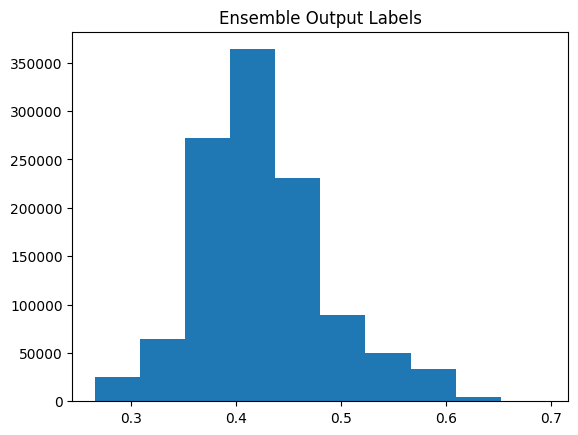

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(ensemble_output.flatten())
plt.title("Ensemble Output Labels")
plt.show()

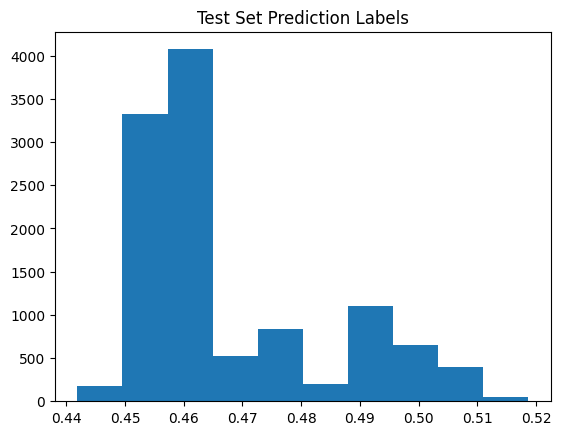

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(mean_pred)
plt.title("Test Set Prediction Labels")
plt.show()

# Graphs

## Training Data

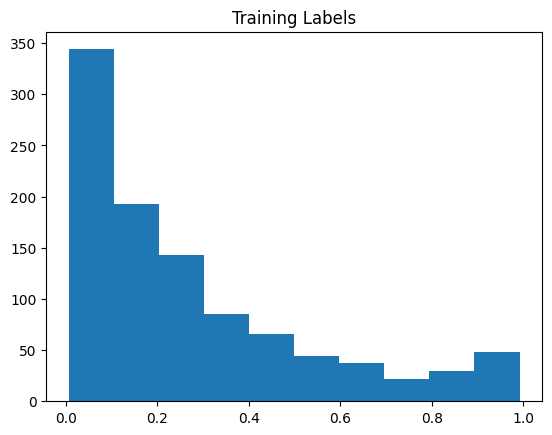

In [66]:
plt.hist(y_train.cpu().numpy())
plt.title("Training Labels")
plt.show()

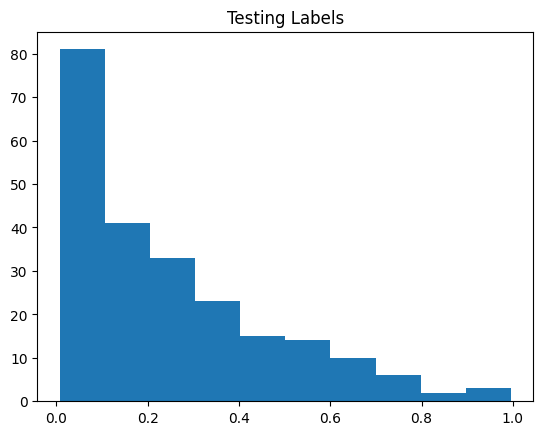

In [67]:
plt.hist(y_test.cpu().numpy())
plt.title("Testing Labels")
plt.show()

## Eval on Training Set

In [80]:
ensemble_output = np.column_stack([model.predict(X_train.cpu().numpy()) for model in lgb_boot_models])
mean_pred = meta_model.predict(ensemble_output)
ensemble_output.shape, mean_pred.shape

((912, 100), (912,))

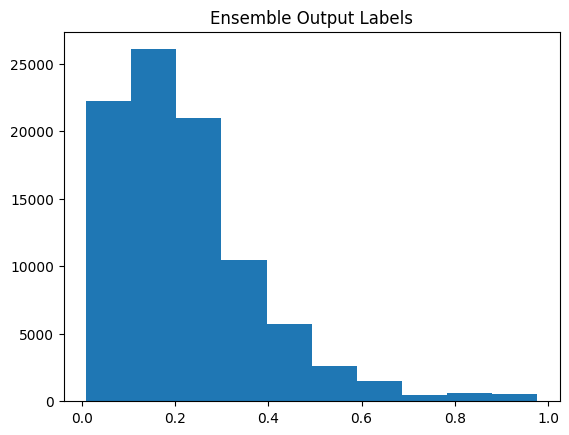

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(ensemble_output.flatten())
plt.title("Ensemble Output Labels")
plt.show()

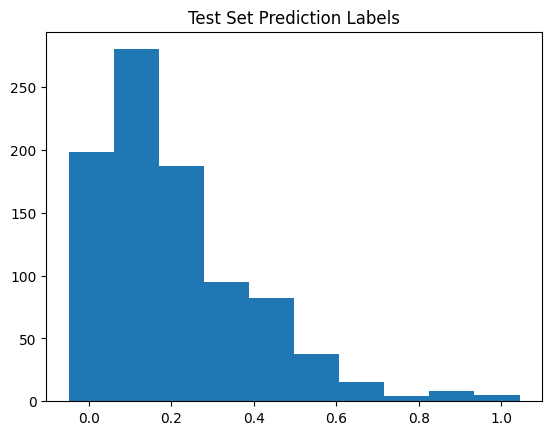

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(mean_pred)
plt.title("Test Set Prediction Labels")
plt.show()

## Query 1 Eval

In [84]:
# load and merge in query 1 results
df_query1 = pd.read_csv('query1.csv')
df_query1.rename(columns={"sequence": "Sequence"}, inplace=True)

# develop embeddings
df_query1["Embedding"] = df_query1["Sequence"].apply(lambda seq: extract_esm_embedding(seq))


In [96]:
X_query1 = np.vstack(df_query1["Embedding"].values)
y_query1 = df_query1["DMS_score"].values.reshape(-1, 1)
ensemble_output = np.column_stack([model.predict(X_query1) for model in lgb_boot_models])
mean_pred = ensemble_output.mean(axis=1)#meta_model.predict(ensemble_output)
ensemble_output.shape, mean_pred.shape

((100, 100), (100,))

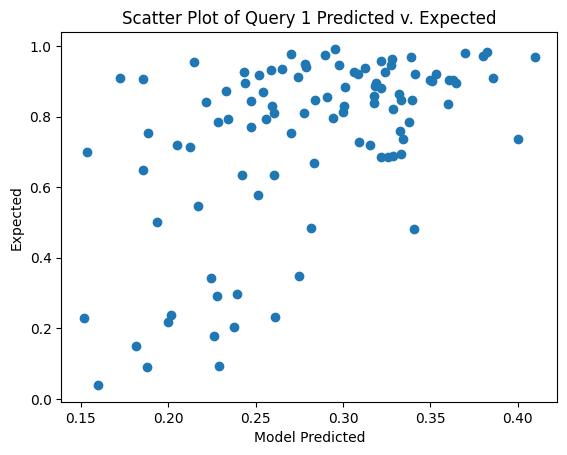

In [97]:
plt.scatter(mean_pred, y_query1)
plt.title("Scatter Plot of Query 1 Predicted v. Expected")
plt.xlabel("Model Predicted")
plt.ylabel("Expected")
plt.show()

In [98]:
from scipy.stats import spearmanr
corr, p_value = spearmanr(mean_pred, y_query1)
corr

np.float64(0.4742274227422742)

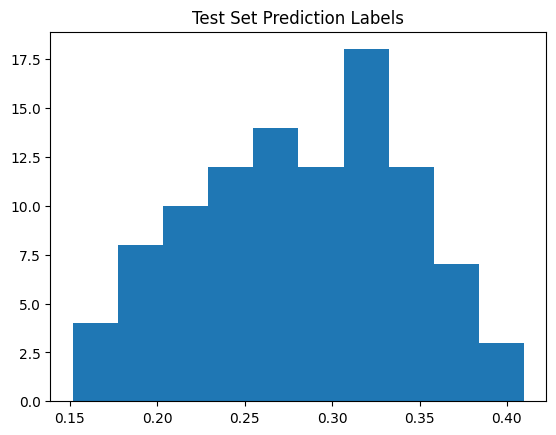

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(mean_pred)
plt.title("Test Set Prediction Labels")
plt.show()